In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.torch.distributions import StudentTOutput

In [4]:
from estimator import TransformerEstimator

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataset = get_dataset("solar_nips", regenerate=False)

In [7]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [8]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [9]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:205: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


In [10]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [29]:
estimator = TransformerEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    lags_seq=[1, 24, 24*7],
    
    nhead=3,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=16,
    
    distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    
    batch_size=64,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1, precision="bf16"),
)

In [30]:
predictor = estimator.train(
    training_data=dataset_train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 7.7 M 
-------------------------------------------
7.7 M     Trainable params
0         Non-trainable par

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 599.08826 (best 599.08826), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_396/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 490.93222 (best 490.93222), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_396/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 450.61819 (best 450.61819), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_396/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 443.86011 (best 443.86011), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_396/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 413.07703 (best 413.07703), saving model to '/mnt/scratch/kashif/pytorch-transfor

In [31]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 34.51it/s]

Running evaluation: 7it [00:00, 115.77it/s]

Running evaluation: 7it [00:00, 114.39it/s]

Running evaluation: 7it [00:00, 111.03it/s]

Running evaluation: 7it [00:00, 114.09it/s]

Running evaluation: 7it [00:00, 114.86it/s]

Running evaluation: 7it [00:00, 116.17it/s]

Running evaluation: 7it [00:00, 113.14it/s]

Running evaluation: 7it [00:00, 112.55it/s]

Running evaluation: 7it [00:00, 112.86it/s]

Running evaluation: 7it [00:00, 111.58it/s]

Running evaluation: 7it [00:00, 111.08it/s]

Running evaluation: 7it [00:00, 110.80it/s]

Running evaluation: 7it [00:00, 112.71it/s]

Running evaluation: 7it [00:00, 113.28it/s]

Running evaluation: 7it [00:00, 109.68it/s]

Running evaluation: 7it [00:00, 110.06it/s]

Running evaluation: 7it [00:00, 111.14it/s]

Running evaluation: 7it [00:00, 114.46it/s]

Running evaluation: 7it [00:00, 115.01it/s]

Running evaluation: 7it [00:00, 114.13it/s]

Running evaluation: 7it [00:00, 113.21it/s]

Running ev

In [32]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3553076852925569
ND: 0.4453666432432859
NRMSE: 0.976368135545307
MSE: 904.284282501348


In [33]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.3117812475478932
ND-Sum: 0.34632397150406236
NRMSE-Sum: 0.7168853086975426
MSE-Sum: 9149941.214285715


In [34]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 3
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile  * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    axx[0].set_title(forecast.item_id)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

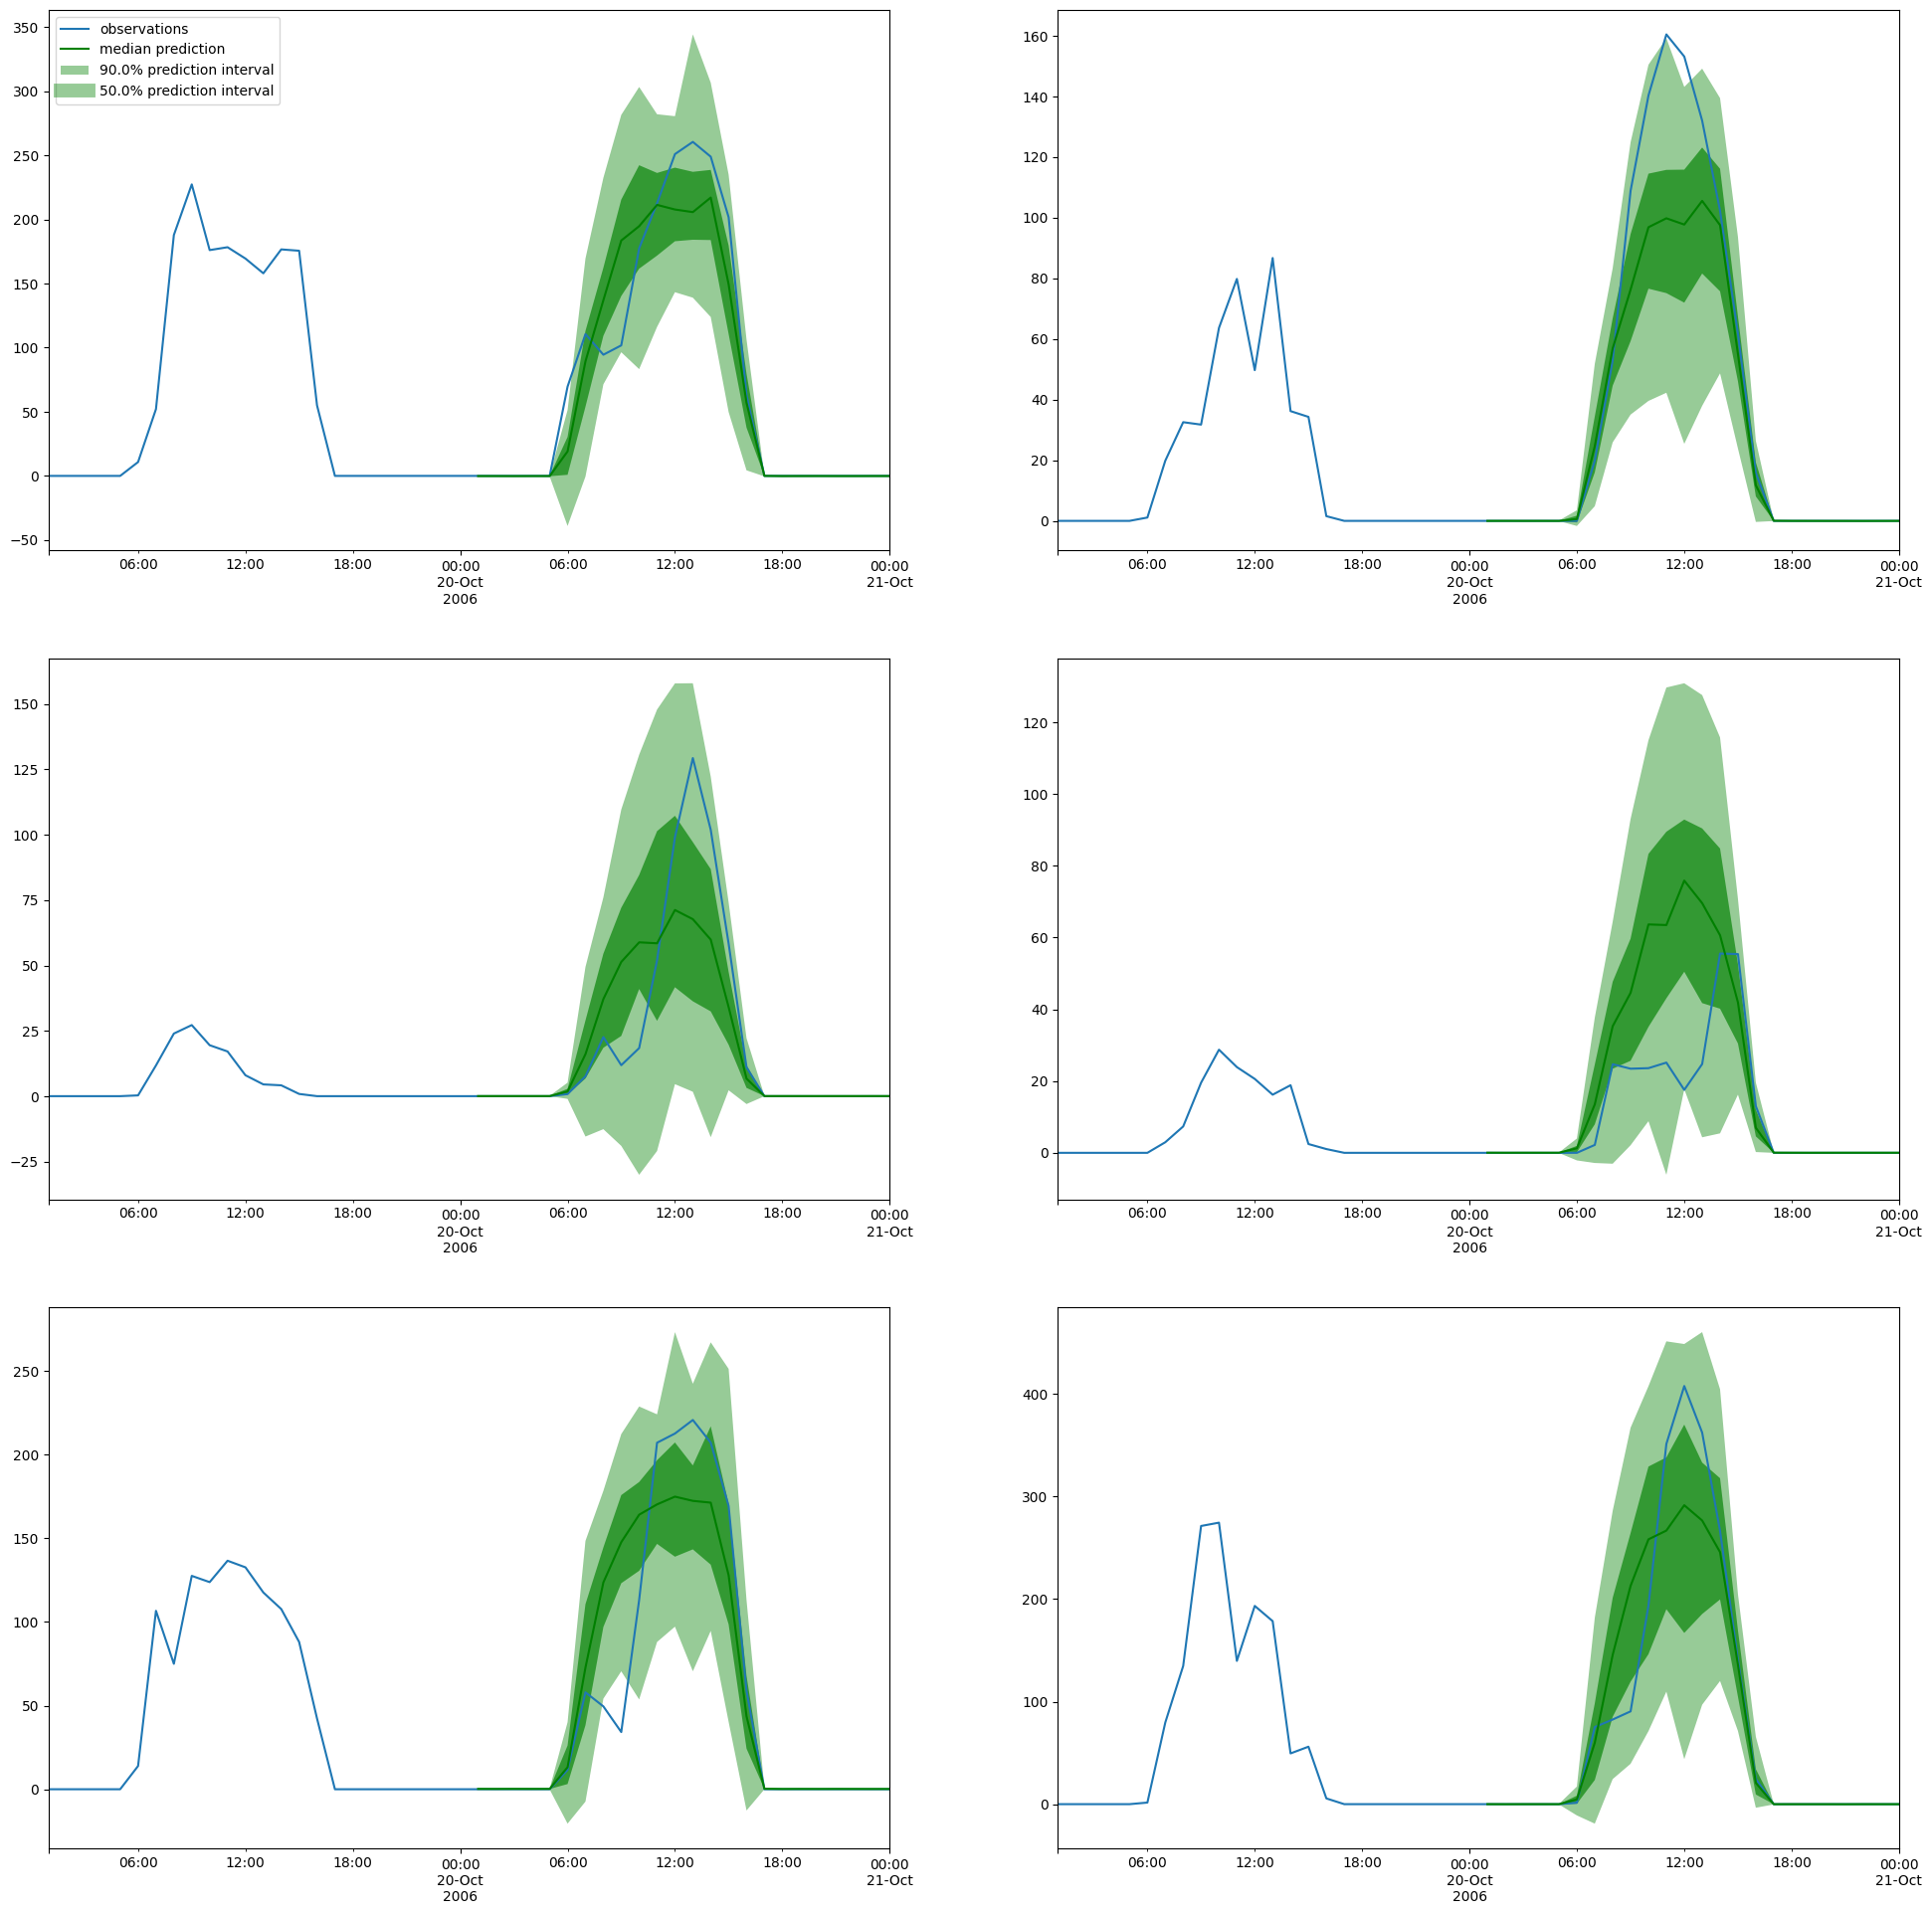

In [35]:
plot(targets[0], forecasts[0], prediction_length=dataset.metadata.prediction_length)